In [1]:
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
import optuna
from optuna.visualization.matplotlib import plot_param_importances
import matplotlib.pyplot as plt
import joblib
from joblib import dump, load
import pandas as pd
from typing import Iterable
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
def inspect_data(data):
    col_name=[]
    col_dtype=[]
    mv_count=[]
    unkown_count=[]
    dtype_correction=[]

    # Converts "unknown" values into np.nan
    for cols in data.columns:
        data.loc[data[cols]=="unknown", cols] = np.nan

    # creates an inspection dataframe
    for cols in data.columns:
        col_name.append(cols.capitalize())
        col_dtype.append(data[cols].dtypes)
        mv_count.append(data[cols].isnull().sum())
        unkown_count.append(data[cols].value_counts().get("unknown", 0))

    # Dataframe above lists
    _ = pd.DataFrame({"Column":col_name,
                     "Data Type":col_dtype,
                     "Missing Values": mv_count,
                     "Unkown Variable":unkown_count})
    return _

def replace_categorical_with_indices(data)->list:
  # Filter columns with "Object" datatype
  categorical_variables = data.select_dtypes("object")
  categorical_column_list = list(categorical_variables.columns)

  # Create a dictionary of keys and values for "Object" datatype columns
  categorical_column_dict = {}
  for cv in categorical_column_list:
      categorical_column_dict[cv] = categorical_variables[cv].unique()

  # Replace unique values with corresponding indices
  for column, values in categorical_column_dict.items():
      value_dict = {value: index for index, value in enumerate(values) if not pd.isnull(value)}
      categorical_variables[column] = categorical_variables[column].replace(value_dict)

  # masks categoric variables from numerical columns and replace them with processed version
  numerical_variables = data.loc[:, ~data.columns.isin(categorical_variables.columns)]
  data = pd.concat([numerical_variables, categorical_variables], axis=1)

  return data

In [4]:
train_df = pd.read_csv("/kaggle/input/uci-ml-repository-bank-marketing/bank-additional/bank-additional/bank-additional-full.csv", delimiter=";") 

In [5]:
train_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [6]:
inspect_data(train_df)

,Column,Data Type,Missing Values,Unkown Variable
0,Age,float64,0,0
1,Job,object,330,0
2,Marital,object,80,0
3,Education,object,1731,0
4,Default,object,8597,0
5,Housing,object,990,0
6,Loan,object,990,0
7,Contact,object,0,0
8,Month,object,0,0
9,Day_of_week,object,0,0


In [7]:
processed_train_df = replace_categorical_with_indices(train_df)
processed_train_df.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
0,56.0,261.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
1,57.0,149.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,1.0,NaN,0.0,0.0,0,0,0,0,0
2,37.0,226.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,1.0,0.0,1.0,0.0,0,0,0,0,0
3,40.0,151.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,2.0,0.0,0.0,0.0,0,0,0,0,0
4,56.0,307.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,1.0,0.0,0.0,1.0,0,0,0,0,0


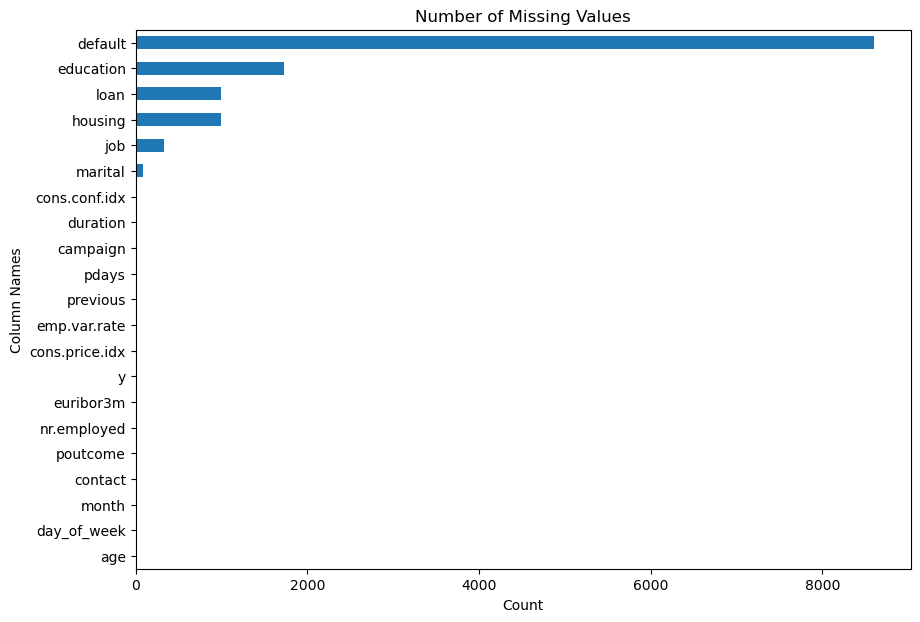

In [8]:
plt.figure(figsize=(10,7))
processed_train_df.isnull().sum().sort_values().plot(kind="barh", title="Number of Missing Values");
plt.xlabel("Count");
plt.ylabel("Column Names");

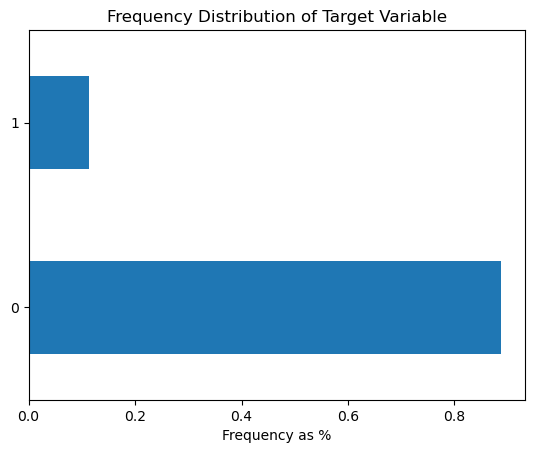

In [9]:
processed_train_df.y.value_counts(normalize=True).plot(kind="barh", title="Frequency Distribution of Target Variable");plt.xlabel("Frequency as %");

In [10]:
knn_imputer = KNNImputer(missing_values=np.nan,
                        weights="distance",
                        metric="nan_euclidean")
processed_train_df = knn_imputer.fit_transform(processed_train_df)
processed_train_df = pd.DataFrame(processed_train_df, columns=[train_df.columns])

In [13]:
X = processed_train_df.drop(["y"], axis=1)
y = processed_train_df["y"]

print(f"x Data Shape {X.shape}, \ny Data Shape {y.shape}")

x Data Shape (41188, 20), 
 y Data Shape (41188, 1)


In [15]:
# SMOTE Application
smote = SMOTE(sampling_strategy="not majority",
              random_state=42)
X, y = smote.fit_resample(X, y)
print(y.value_counts(normalize=True))

(y,)
0.0     0.5
1.0     0.5
dtype: float64


In [17]:
# Model Fit
estimator = XGBClassifier()
feature_selector = RFECV(estimator=estimator,
                         step=1,
                         cv=5,
                         scoring="accuracy")
# Wrapper fit
feature_selector.fit(X, y)

RFECV(cv=5,
      estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...),
      scoring='accuracy')

In [18]:
# Cross-validation results
rfecv_output = feature_selector.cv_results_

cv_results={}
for key, values in rfecv_output.items():
  cv_results[key] = round(np.mean(values),2)

cv_results = pd.DataFrame.from_dict(cv_results,orient="index",
                                    columns=["Accuracy"])
cv_results

,Accuracy
mean_test_score,0.70
std_test_score,0.18
split0_test_score,0.60
split1_test_score,0.87
split2_test_score,0.94
split3_test_score,0.59
split4_test_score,0.51


In [19]:
# Mask columns with the highest importance
mask = feature_selector.get_support()
features = np.array(X.columns)
best_features = features[mask]

print("Selected best: ", best_features.shape[0])
print(features[mask])

Selected best:  6
[('job',) ('day_of_week',) ('campaign',) ('poutcome',) ('cons.price.idx',)
 ('euribor3m',)]


In [23]:
# Get ranking list
ranking_list = {}
column_names = list(X.columns)
column_names
importance_list = list(feature_selector.ranking_)
for feature, col in zip(importance_list, column_names):
    ranking_list[col] = feature

# Convert dict to pandas dataframe
ranking_list = pd.DataFrame.from_dict(ranking_list,
                                      orient="index",
                                      columns=["Ranking"]).sort_values(by="Ranking")
# importance ranking
best_ranking = ranking_list.loc[ranking_list["Ranking"]==1]
best_ranking.index = [str(col).replace("(", "").replace(")", "").replace(",", "").replace("'", "") for col in best_ranking.index]
best_ranking

,Ranking
day_of_week,1
job,1
cons.price.idx,1
poutcome,1
campaign,1
euribor3m,1


In [24]:
X_best = X[list(best_ranking.index.values)]
best_X_train, best_X_test, y_train, y_test = train_test_split(X_best, y,
                                                              test_size=0.25,
                                                              random_state=42)

In [25]:
print(f"best X_train shape: {best_X_train.shape} \ny_train shape: {y_train.shape} \nbest X_test shape: {best_X_test.shape} \ny_test shape:{y_test.shape}")

best X_train shape: (54822, 6) 
y_train shape: (54822, 1) 
best X_test shape: (18274, 6) 
y_test shape:(18274, 1)


In [26]:
# Pipeline with Model and MinMaxScaler
pipeline = Pipeline([("MMS",MinMaxScaler()),
                     ("XGBM", XGBClassifier(random_state=42))])
# Hyperparameters
XGBM_parameters = [{"XGBM__learning_rate":[0.01, 0.05, 0.1],
                    "XGBM__n_estimators":[1000, 2000, 3000],
                    "XGBM__max_depth":[3, 5, 7],
                    "XGBM__subsample":[0.5, 0.6, 0.7],
                    "XGBM__gamma":[1,3,5],
                    "XGBM__colsample_bytree":[0.5, 0.6, 0.7],
                    "XGBM__reg_alpha":[0.1, 0.3, 0.5],
                    "XGBM__reg_lambda":[0.1, 0.3, 0.5],
                    "XGBM__min_child_weight":[0.1, 0.3, 0.5],
                    }]

In [27]:
# Cross-validation with Randomized Search Grid
xgbm_classifier = RandomizedSearchCV(estimator=pipeline,
                                     param_distributions=XGBM_parameters,
                                     scoring="accuracy",
                                     verbose=2,
                                     random_state=42)
# RandomizedSearchCV model fitting
xgbm_classifier.fit(best_X_train, y_train)
xgbm_preds=xgbm_classifier.predict(best_X_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END XGBM__colsample_bytree=0.7, XGBM__gamma=3, XGBM__learning_rate=0.01, XGBM__max_depth=7, XGBM__min_child_weight=0.1, XGBM__n_estimators=1000, XGBM__reg_alpha=0.1, XGBM__reg_lambda=0.1, XGBM__subsample=0.5; total time=  19.5s
[CV] END XGBM__colsample_bytree=0.7, XGBM__gamma=3, XGBM__learning_rate=0.01, XGBM__max_depth=7, XGBM__min_child_weight=0.1, XGBM__n_estimators=1000, XGBM__reg_alpha=0.1, XGBM__reg_lambda=0.1, XGBM__subsample=0.5; total time=  21.3s
[CV] END XGBM__colsample_bytree=0.7, XGBM__gamma=3, XGBM__learning_rate=0.01, XGBM__max_depth=7, XGBM__min_child_weight=0.1, XGBM__n_estimators=1000, XGBM__reg_alpha=0.1, XGBM__reg_lambda=0.1, XGBM__subsample=0.5; total time=  20.7s
[CV] END XGBM__colsample_bytree=0.7, XGBM__gamma=3, XGBM__learning_rate=0.01, XGBM__max_depth=7, XGBM__min_child_weight=0.1, XGBM__n_estimators=1000, XGBM__reg_alpha=0.1, XGBM__reg_lambda=0.1, XGBM__subsample=0.5; total time=  19.4s
[CV] EN

In [28]:
# CV Accuracy and Best Parameter Selection
print("XGBClassifier Accuracy: {:.3f}".format(accuracy_score(y_test, xgbm_preds)),
      "\nBest Parameters: {}".format(xgbm_classifier.best_params_))

XGBClassifier Accuracy: 0.941 
Best Parameters: {'XGBM__subsample': 0.7, 'XGBM__reg_lambda': 0.3, 'XGBM__reg_alpha': 0.1, 'XGBM__n_estimators': 1000, 'XGBM__min_child_weight': 0.3, 'XGBM__max_depth': 7, 'XGBM__learning_rate': 0.05, 'XGBM__gamma': 1, 'XGBM__colsample_bytree': 0.7}


In [29]:
# re-fit the best model
best_cv_model = XGBClassifier(subsample=0.7, reg_lambda=0.3, n_estimators=1000,
                              min_child_weight=0.3, max_depth=7, learning_rate=0.05,
                              gamma=1, colsample_bytree=0.7
                            )
best_cv_model.fit(best_X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=0.3, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [32]:
# save best model
dump(best_cv_model, filename="xgbclassifier.joblib")
# load model
best_model = joblib.load("/kaggle/working/xgbclassifier.joblib")

In [33]:
best_model.fit(best_X_train, y_train)
y_pred = best_model.predict(best_X_test)

In [34]:
y.value_counts(normalize=True)

(y,)
0.0     0.5
1.0     0.5
dtype: float64

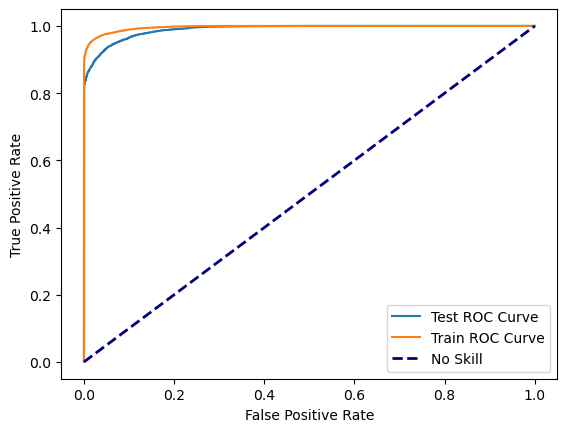

In [35]:
# test prediction probabilities
test_pred_proba = best_model.predict_proba(best_X_test)
test_pos_probs = test_pred_proba[:, 1]

# train prediction probabilities
train_pred_proba = best_model.predict_proba(best_X_train)
train_pos_probs = train_pred_proba[:, 1]

# test / train precision, recall, and thresholds
test_fpr, test_tpr, test_threshold = roc_curve(y_test, test_pos_probs)
train_fpr, train_tpr, train_threshold = roc_curve(y_train, train_pos_probs)

# Display ROC Curve
plt.plot(test_fpr, test_tpr,  label='Test ROC Curve')
plt.plot(train_fpr, train_tpr,  label='Train ROC Curve')
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="No Skill")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="best")
plt.show()

In [36]:
print(classification_report(y_test, y_pred, target_names=["No","Yes"]))

              precision    recall  f1-score   support

          No       0.93      0.95      0.94      9167
         Yes       0.95      0.93      0.94      9107

    accuracy                           0.94     18274
   macro avg       0.94      0.94      0.94     18274
weighted avg       0.94      0.94      0.94     18274



In [37]:
# RSCV-Optimized Model
accuracy_score(y_test, y_pred)

0.9414468643975047

In [38]:
# Selected Features based on importance
imb_X = X[["job","marital","housing","loan","campaign","pdays",
            "poutcome","cons.price.idx","cons.conf.idx", "euribor3m",
            "nr.employed"]]

# Split train and validation
imb_X_train, imb_X_test, imb_y_train, imb_y_test = train_test_split(imb_X,y,test_size=0.25, random_state=42)

In [39]:
# Pipeline with Model and MinMaxScaler
imb_pipeline = Pipeline([("MMS",MinMaxScaler()),
                     ("XGBM", XGBClassifier(random_state=42))])
# Hyperparameters
XGBM_parameters_imb = [{"XGBM__learning_rate":[0.01, 0.1, 0.2],
                    "XGBM__n_estimators":[1000, 2000],
                    "XGBM__max_depth":[3, 5, 7],
                    "XGBM__subsample":[0.5, 0.6],
                    "XGBM__gamma":[1,3],
                    "XGBM__colsample_bytree":[0.5, 0.6],
                    "XGBM__reg_alpha":[0.1, 0.3],
                    "XGBM__reg_lambda":[0.1, 0.3],
                    "XGBM__min_child_weight":[0.1, 0.3],
                    }]

In [40]:
# Cross-validation with Randomized Search Grid
imb_xgbm_classifier = RandomizedSearchCV(estimator=imb_pipeline,
                                     param_distributions=XGBM_parameters_imb,
                                     scoring="accuracy",
                                     verbose=2,
                                     random_state=42)
# RandomizedSearchCV model fitting
imb_xgbm_classifier.fit(imb_X_train, imb_y_train)
imb_xgbm_preds=imb_xgbm_classifier.predict(imb_X_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END XGBM__colsample_bytree=0.6, XGBM__gamma=3, XGBM__learning_rate=0.2, XGBM__max_depth=7, XGBM__min_child_weight=0.1, XGBM__n_estimators=1000, XGBM__reg_alpha=0.3, XGBM__reg_lambda=0.3, XGBM__subsample=0.5; total time=  27.4s
[CV] END XGBM__colsample_bytree=0.6, XGBM__gamma=3, XGBM__learning_rate=0.2, XGBM__max_depth=7, XGBM__min_child_weight=0.1, XGBM__n_estimators=1000, XGBM__reg_alpha=0.3, XGBM__reg_lambda=0.3, XGBM__subsample=0.5; total time=  24.7s
[CV] END XGBM__colsample_bytree=0.6, XGBM__gamma=3, XGBM__learning_rate=0.2, XGBM__max_depth=7, XGBM__min_child_weight=0.1, XGBM__n_estimators=1000, XGBM__reg_alpha=0.3, XGBM__reg_lambda=0.3, XGBM__subsample=0.5; total time=  26.1s
[CV] END XGBM__colsample_bytree=0.6, XGBM__gamma=3, XGBM__learning_rate=0.2, XGBM__max_depth=7, XGBM__min_child_weight=0.1, XGBM__n_estimators=1000, XGBM__reg_alpha=0.3, XGBM__reg_lambda=0.3, XGBM__subsample=0.5; total time=  26.1s
[CV] END XG

In [41]:
# Fit Model and Predict
imb_pred = imb_xgbm_classifier.predict(imb_X_test)
print("XGBClassifier Precision Score: {:.3f}".format(average_precision_score(imb_y_test, imb_pred)),
      "\nBest Parameters: {}".format(imb_xgbm_classifier.best_params_))

XGBClassifier Precision Score: 0.934 
Best Parameters: {'XGBM__subsample': 0.6, 'XGBM__reg_lambda': 0.3, 'XGBM__reg_alpha': 0.3, 'XGBM__n_estimators': 1000, 'XGBM__min_child_weight': 0.3, 'XGBM__max_depth': 7, 'XGBM__learning_rate': 0.01, 'XGBM__gamma': 1, 'XGBM__colsample_bytree': 0.5}


In [42]:
imb_model = XGBClassifier(subsample=0.6, reg_lambda=0.3, reg_alpha=0.3,
                          n_estimators=1000, min_child_weight=0.3, max_depth=7,
                          learning_rate=0.01, gamma=1, colsample_bytree=0.5)
imb_model.fit(imb_X_train, imb_y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=0.3, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [43]:
# Label Distribution
y.value_counts(normalize=True)

(y,)
0.0     0.5
1.0     0.5
dtype: float64

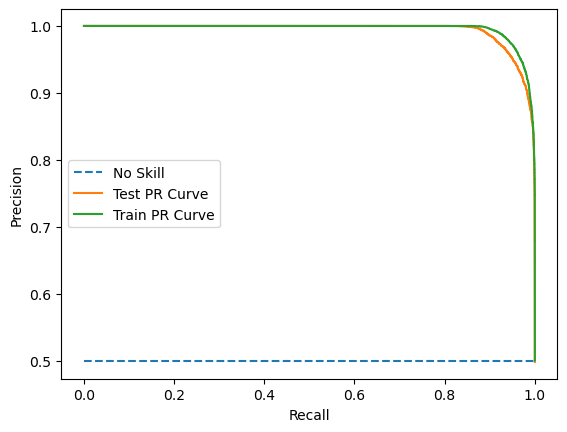

In [45]:
# test prediction probabilities
test_pred_proba = imb_model.predict_proba(imb_X_test)
test_pos_probs = test_pred_proba[:, 1]

# train prediction probabilities
train_pred_proba = imb_model.predict_proba(imb_X_train)
train_pos_probs = train_pred_proba[:, 1]

# calculate the no skill line as the proportion of the positive class
no_skill = 0.5

# Precision-Recall Curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

# test / train precision, recall, and thresholds
test_precision, test_recall, test_threshold = precision_recall_curve(imb_y_test, test_pos_probs)
train_precision, train_recall, train_threshold =precision_recall_curve(imb_y_train, train_pos_probs)

# Display PR Curve
plt.plot(test_recall, test_precision,  label='Test PR Curve')
plt.plot(train_recall, train_precision,  label='Train PR Curve')
plt.xlabel('Recall');plt.ylabel('Precision');plt.legend();

In [46]:
print(classification_report(imb_y_test, imb_pred, target_names=["No","Yes"]))

              precision    recall  f1-score   support

          No       0.94      0.96      0.95      9167
         Yes       0.96      0.94      0.95      9107

    accuracy                           0.95     18274
   macro avg       0.95      0.95      0.95     18274
weighted avg       0.95      0.95      0.95     18274



In [48]:
# save best model
dump(imb_xgbm_classifier, filename="imb_xgbclassifier.joblib")

['imb_xgbclassifier.joblib']